In [1]:
%matplotlib inline
from matplotlib import rcParams
rcParams["savefig.dpi"] = 100

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import leastsq

In [3]:
from exoabc.sim import DR24CompletenessModel

In [4]:
inj = pd.read_csv("data/q1_q17_dr24/injections.csv")
robo = pd.read_csv("data/q1_q17_dr24/robovetter.csv")

In [55]:
joined = pd.merge(inj, robo, left_on=("kepid", "period"), right_on=("KIC", "injPer"), how="left")
print(len(inj), len(joined), np.sum((joined.recovered==1) & joined.KIC.isnull()))
joined = pd.DataFrame(joined[(joined.offset_from_source == 0) & (joined.expect_mes > 1.0)
                             & (joined.period > 10.0) & (joined.period < 100.0)])

159013 159013 0


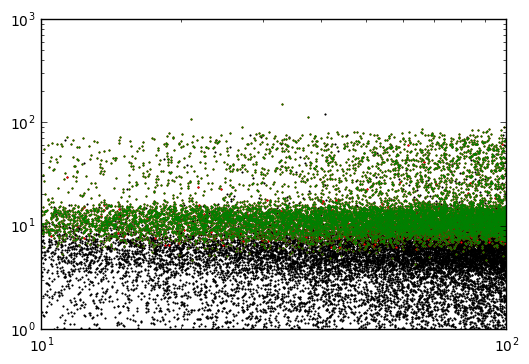

In [56]:
x = np.array(joined.period)
y = np.array(joined.expect_mes)
m_rec = np.array(joined.recovered == 1)
m_robo = np.array(joined.Disp == "PC")
m_all = m_rec & m_robo
z = 1.0 * m_all

plt.loglog(x[~m_all], y[~m_all], ".k", ms=2)
plt.loglog(x[m_rec], y[m_rec], ".r", ms=2)
plt.loglog(x[m_robo], y[m_robo], ".g", ms=2);

In [57]:
(y <= 0).sum()

0

In [58]:
# Compute the weights (prior) model.
N_all, X, Y = np.histogram2d(np.log(x), np.log(y), (12, 13))
inds_x = np.clip(np.digitize(np.log(x), X) - 1, 0, len(X) - 2)
inds_y = np.clip(np.digitize(np.log(y), Y) - 1, 0, len(Y) - 2)
w = np.sqrt(N_all[inds_x, inds_y])

N_rec, X, Y = np.histogram2d(np.log(x[m_all]), np.log(y[m_all]), (X, Y))

frac = N_rec / N_all
frac[np.isnan(frac)] = 0.0

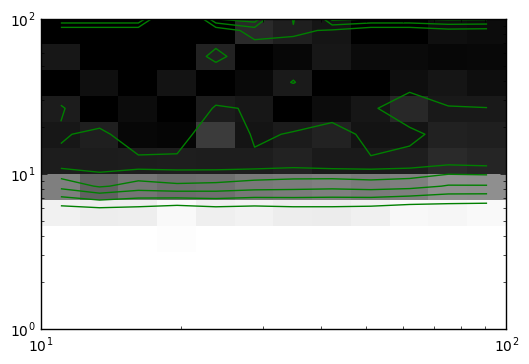

In [59]:
plt.pcolor(np.exp(X), np.exp(Y), frac.T, cmap="gray_r")
plt.contour(np.exp(0.5*(X[:-1]+X[1:])), np.exp(0.5*(Y[:-1]+Y[1:])), frac.T, colors="g")
plt.xscale("log")
plt.yscale("log")
plt.ylim(1.0, 100);

In [60]:
# Fit the completeness model.
p0 = np.array([0.0, 0.0, 0.7, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0])
completeness_model = DR24CompletenessModel()
resid = lambda p: (z - completeness_model.get_pdet(p, x, y)) / w
params, _, info, msg, flag = leastsq(resid, p0, full_output=True)

In [61]:
params

array([  0.02828606,  -0.2185952 ,   1.33018107,   0.32791225,
        -2.05480672,  11.25056276,   0.08386963,  -0.5797063 ,   0.86813801])

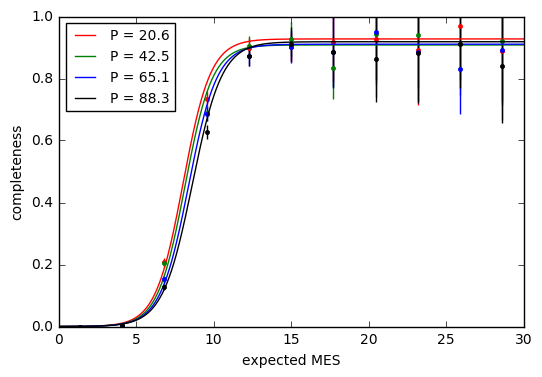

In [62]:
fig = plt.figure()
ax = fig.add_subplot(111)
q = np.exp(np.percentile(np.log(x), [25, 50, 75]))
b = np.linspace(0, 30, 12)
y2 = np.linspace(0, 30, 1000)
for mn, mx, c in zip(np.append(x.min(), q), np.append(q, x.max()), "rgbk"):
    m = (mn <= x) & (x < mx)
    n_tot, _ = np.histogram(y[m], b)
    n_rec, _ = np.histogram(y[m][z[m] > 0], b)
    n = n_rec / n_tot
    ax.errorbar(0.5*(b[:-1] + b[1:]), n, yerr=n / np.sqrt(n_rec), fmt=".",
                color=c, capsize=0)
    z2 = completeness_model.get_pdet(params, 0.5*(mn+mx)+np.zeros_like(y2),
                                     y2)
    ax.plot(y2, z2, color=c, label="P = {0:.1f}".format(0.5*(mn+mx)))
# ax.set_xlim(0, 3*mesthresh)
ax.set_xlabel("expected MES")
ax.set_ylabel("completeness")
ax.legend(loc=2, fontsize=10);